In [1]:
import requests
from datetime import datetime, timedelta
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from draw_map import  BORDER_LINES, drawKorea, drawKoreaMinus

In [3]:
# 측정소별 실시간 측정정보 조회 (매시 15분 내외 업데이트)
base_url = "http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty"
with open('keys/에어코리아api.txt') as file:
    service_key = file.read()       # 발급받은 에어코리아 API 키 입력

#### 데이터 csv파일변환

In [1]:
import requests
import pandas as pd
from draw_map import  BORDER_LINES, drawKorea, drawKoreaMinus

# 기본 URL 및 API 키 설정
base_url = "http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty"
with open('keys/에어코리아api.txt') as file:
    service_key = file.read()  # 발급받은 에어코리아 API 키 입력

# 예제 데이터프레임 생성
main = pd.read_csv('data/카토그램_최종.csv', encoding='utf-8')

# 완성코드
def get_air_quality():
    # 결과를 저장할 리스트
    results_list = []

    # 요청을 나누어 보내기
    chunk_size = 50
    max_retries = 3

    for i in range(0, len(main), chunk_size):
        chunk = main.iloc[i:i+chunk_size]
        
        # 각 측정소에 대한 데이터 수집
        for index, row in chunk.iterrows():
            retry_count = 0

            while retry_count < max_retries:
                try:
                    params = {
                        'serviceKey': service_key,
                        'returnType': 'JSON',
                        'numOfRows': 24,
                        'pageNo': 1,
                        'stationName': row['측정소명'],
                        'dataTerm': 'DAILY',
                        'ver': "1.4"
                    }

                    res = requests.get(url=base_url, params=params)

                    # 응답 데이터 정리
                    response = res.json()['response']['body']
                    
                    # 데이터가 존재하면 처리
                    if 'items' in response and response['items']:
                        data = response['items']
                        
                        # 데이터를 날짜와 시간에 대한 기준으로 정렬
                        sorted_data = sorted(data, key=lambda x: x['dataTime'], reverse=True)

                        # 최신 데이터 선택
                        latest_data = None

                        for data in sorted_data:
                            pm10_value = data.get('pm10Value')
                            if pm10_value and pm10_value != '-':
                                latest_data = data
                                break

                        # 최신 데이터가 없으면 첫 번째 데이터 선택
                        if not latest_data and sorted_data:
                            latest_data = sorted_data[0]

                        result = {
                            '날짜': latest_data['dataTime'],
                            '이름': latest_data['stationName'],
                            '측정망 정보': latest_data['mangName'],
                            '아황산가스 농도': latest_data['so2Value'],
                            '일산화탄소 농도': latest_data['coValue'],
                            '오존 농도': latest_data['o3Value'],
                            '이산화질소 농도': latest_data['no2Value'],
                            '미세먼지(PM10) 농도': latest_data.get('pm10Value'),
                            '초미세먼지(PM2.5) 농도': latest_data.get('pm25Value')
                        }

                        results_list.append(result)
                        break  # 성공한 경우 while 루프 종료
                    else:
                        results_list.append({})
                        break  # 성공했지만 데이터가 비어있는 경우 while 루프 종료

                except requests.exceptions.RequestException as e:
                    print(f"Request failed: {e}")
                    retry_count += 1
                    print(f"Retrying... (Attempt {retry_count}/{max_retries})")

                    if retry_count == max_retries:
                        print(f"Max retries reached. Skipping request for {row['측정소명']}")
                        break  # 최대 재시도 횟수에 도달하면 while 루프 종료

    # 결과 리스트의 길이를 250개로 맞추기
    results_list.extend([{}] * (len(main) - len(results_list)))

    # 리스트를 DataFrame으로 변환
    df = pd.DataFrame(results_list)

    # DataFrame을 CSV 파일로 저장
    df.to_csv('data/측정소별대기질_final.csv', index=False)
    
# 공기 품질 데이터를 얻기 위해 함수 호출
get_air_quality()

Request failed: HTTPConnectionPool(host='apis.data.go.kr', port=80): Max retries exceeded with url: /B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty?serviceKey=nBg%2BHwr%2FAcIl8mQ6pviMUSuy9Te5CDEJKfw5CIJn6tTDevZ5u3SL7vCng8%2BlzQcmLlJ7o6Eqy91xpF%2B4UMQzGA%3D%3D&returnType=JSON&numOfRows=24&pageNo=1&stationName=%EC%A2%85%EB%A1%9C%EA%B5%AC&dataTerm=DAILY&ver=1.4 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x000001BD79F64C10>, 'Connection to apis.data.go.kr timed out. (connect timeout=None)'))
Retrying... (Attempt 1/3)
Request failed: HTTPConnectionPool(host='apis.data.go.kr', port=80): Max retries exceeded with url: /B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty?serviceKey=nBg%2BHwr%2FAcIl8mQ6pviMUSuy9Te5CDEJKfw5CIJn6tTDevZ5u3SL7vCng8%2BlzQcmLlJ7o6Eqy91xpF%2B4UMQzGA%3D%3D&returnType=JSON&numOfRows=24&pageNo=1&stationName=%EC%A4%91%EA%B5%AC&dataTerm=DAILY&ver=1.4 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object

#### csv파일로 카토그램만들기

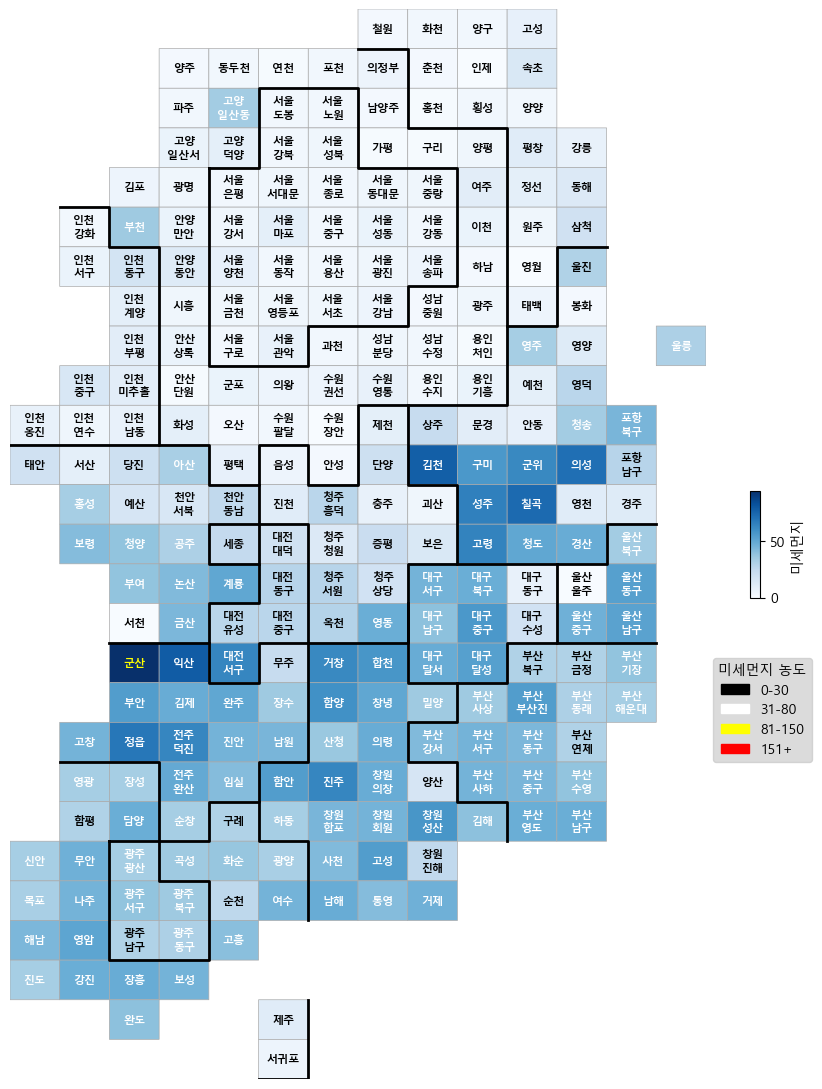

In [1]:
import requests
import pandas as pd
from draw_map import  BORDER_LINES, drawKorea, drawKoreaMinus

# 데이터프레임 생성
main = pd.read_csv('data/카토그램_최종.csv', encoding='utf-8')
air = pd.read_csv('data/측정소별대기질_final.csv', encoding='utf-8')

# '미세먼지(PM10) 농도' 컬럼을 숫자로 변환하고, 빈데이터는 0으로 처리한다.
air['미세먼지(PM10) 농도'] = pd.to_numeric(air['미세먼지(PM10) 농도'], errors='coerce').fillna(0)

# main '미세먼지' 컬럼에 넣기
main['미세먼지'] = air['미세먼지(PM10) 농도']

drawKorea('미세먼지', main, 'Blues')



- API 호출 후 카토그램까지 바로 만들기

Request failed: HTTPConnectionPool(host='apis.data.go.kr', port=80): Max retries exceeded with url: /B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty?serviceKey=hEPJomF9halZMLyNeVJnZkIiItfiPoK6Sor1FqRCJ8%2FzPSaaB8K67cymZEcR0Rznk2BcIf2g2hBkEAABWo6CQQ%3D%3D&returnType=JSON&numOfRows=1&pageNo=1&stationName=%EB%8F%99%EB%8C%80%EB%AC%B8%EA%B5%AC&dataTerm=DAILY&ver=1.4 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x000001E546B77650>, 'Connection to apis.data.go.kr timed out. (connect timeout=None)'))
Retrying... (Attempt 1/3)
Request failed: HTTPConnectionPool(host='apis.data.go.kr', port=80): Max retries exceeded with url: /B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty?serviceKey=hEPJomF9halZMLyNeVJnZkIiItfiPoK6Sor1FqRCJ8%2FzPSaaB8K67cymZEcR0Rznk2BcIf2g2hBkEAABWo6CQQ%3D%3D&returnType=JSON&numOfRows=1&pageNo=1&stationName=%EC%96%91%EC%96%91%EC%9D%8D&dataTerm=DAILY&ver=1.4 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection ob

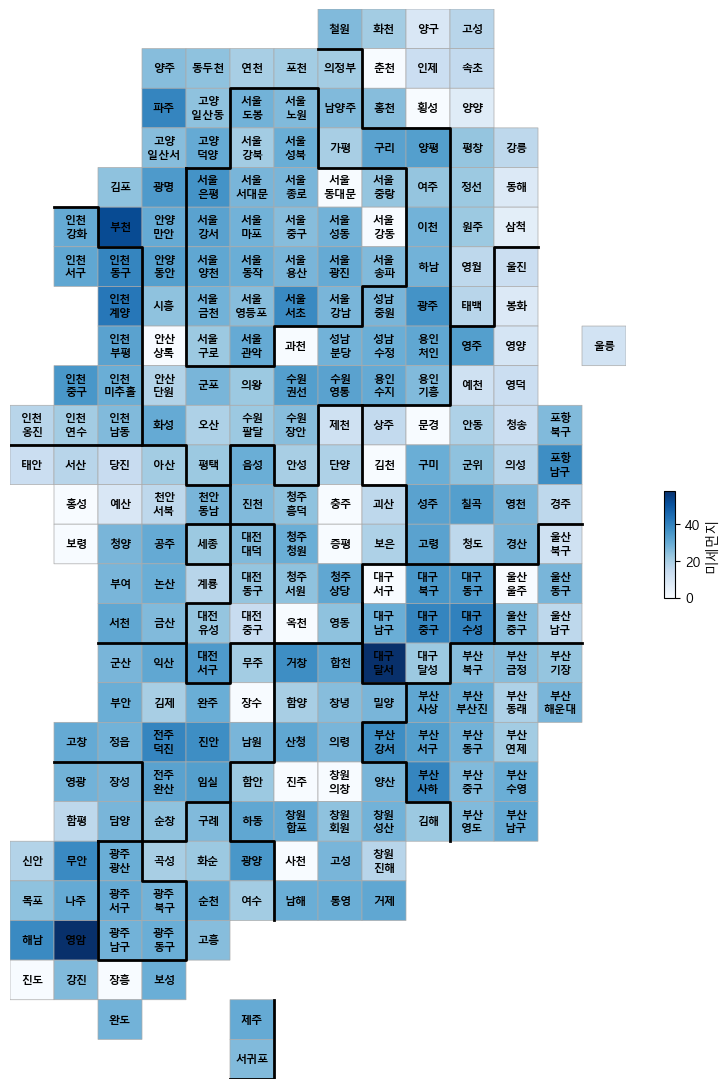

In [13]:
import requests
import pandas as pd

# 기본 URL 및 API 키 설정
base_url = "http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty"
with open('keys/에어코리아api2.txt') as file:
    service_key = file.read()  # 발급받은 에어코리아 API 키 입력

# 예제 데이터프레임 생성
main = pd.read_csv('data/카토그램_최종.csv', encoding='utf-8')

# 결과를 저장할 리스트
results_list = []

# 요청을 나누어 보내기
chunk_size = 50
max_retries = 3

for i in range(0, len(main), chunk_size):
    chunk = main.iloc[i:i+chunk_size]
    
    # 각 측정소에 대한 데이터 수집
    for index, row in chunk.iterrows():
        retry_count = 0

        while retry_count < max_retries:
            try:
                params = {
                    'serviceKey': service_key,
                    'returnType': 'JSON',
                    'numOfRows': 1,
                    'pageNo': 1,
                    'stationName': row['측정소명'],
                    'dataTerm': 'DAILY',
                    'ver': "1.4"
                }

                res = requests.get(url=base_url, params=params)

                # 응답 데이터 정리
                response = res.json()['response']['body']

                if 'items' in response and response['items']:
                    data = response['items']
                    latest_data = data[0]
                    
                    result = {
                        '날짜': latest_data['dataTime'],
                        '이름': latest_data['stationName'],
                        '측정망 정보': latest_data['mangName'],
                        '아황산가스 농도': latest_data['so2Value'],
                        '일산화탄소 농도': latest_data['coValue'],
                        '오존 농도': latest_data['o3Value'],
                        '이산화질소 농도': latest_data['no2Value'],
                        '미세먼지(PM10) 농도': latest_data.get('pm10Value', 0),
                        '초미세먼지(PM2.5) 농도': latest_data.get('pm25Value', 0)
                    }

                    results_list.append(result)
                    break  # 성공한 경우 while 루프 종료
                else:
                    results_list.append({})
                    break  # 성공했지만 데이터가 비어있는 경우 while 루프 종료

            except requests.exceptions.RequestException as e:
                print(f"Request failed: {e}")
                retry_count += 1
                print(f"Retrying... (Attempt {retry_count}/{max_retries})")

                if retry_count == max_retries:
                    print(f"Max retries reached. Skipping request for {row['측정소명']}")
                    break  # 최대 재시도 횟수에 도달하면 while 루프 종료

# 결과 리스트의 길이를 250개로 맞추기
results_list.extend([{}] * (len(main) - len(results_list)))

# '미세먼지' 데이터를 숫자로 변환하고, 빈 데이터는 0으로 변경
main['미세먼지'] = pd.to_numeric([entry.get('미세먼지(PM10) 농도', 0) for entry in results_list], errors='coerce')
main['미세먼지'] = main['미세먼지'].fillna(0)

# '미세먼지' 처리 이후에 그래프 그리기
drawKorea('미세먼지', main, 'Blues', save_filename='카토그램.png')



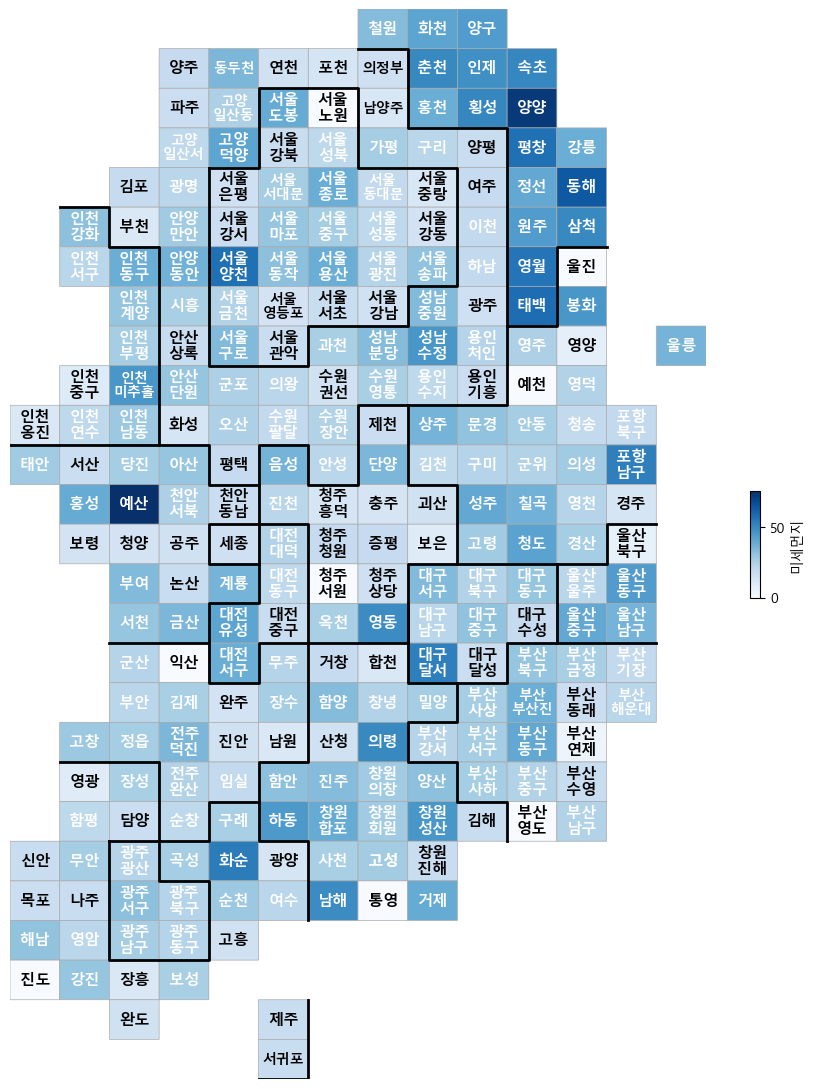

In [ ]:
import requests
import pandas as pd
from draw_map import  BORDER_LINES, drawKorea, drawKoreaMinus

# 측정소별 실시간 측정정보 조회 (매시 15분 내외 업데이트)
base_url = "http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty"
with open('keys/에어코리아api4.txt') as file:
    service_key = file.read()       # 발급받은 에어코리아 API 키 입력

# 예제 데이터프레임 생성
station_Name = pd.read_csv('data/전국 대기측정소_완료.csv', encoding='utf-8')
pop = pd.read_csv('data/카토그램.csv', encoding='utf-8')

# 완성코드
def get_air_quality():
    # 결과를 저장할 리스트
    results_list = []
    
    # 각 측정소에 대한 데이터 수집
    for index, row in station_Name.iterrows():
        # 웹 요청시 같이 전달될 데이터 = 요청 메시지
        params = {
            'serviceKey' : service_key,
            'returnType' : 'JSON',
            'numOfRows' : 10,
            'pageNo' : 1,
            'stationName' : row['측정소명'],  # 각 행의 측정소명을 선택
            'dataTerm' : 'DAILY',
            'ver' : "1.4"  # 오퍼레이션 버전
        }

        res = requests.get(url=base_url , params=params)

        # 응답 데이터 정리
        data = res.json()['response']['body']['items']
        
        # 데이터가 존재하면 처리
        if data:
            # 데이터를 날짜와 시간에 대한 기준으로 정렬
            sorted_data = sorted(data, key=lambda x: x['dataTime'], reverse=True)

            # 최신 데이터 선택
            latest_data = sorted_data[0]

            # 최종 데이터 생성
            result = {
                '날짜': latest_data['dataTime'],
                '이름': latest_data['stationName'],
                '측정망 정보': latest_data['mangName'],
                '아황산가스 농도': latest_data['so2Value'],
                '일산화탄소 농도': latest_data['coValue'],
                '오존 농도': latest_data['o3Value'],
                '이산화질소 농도': latest_data['no2Value'],
                '미세먼지(PM10) 농도': latest_data['pm10Value'],
                '초미세먼지(PM2.5) 농도': latest_data['pm25Value']
            }

            # 결과 리스트에 추가
            results_list.append(result)


    # pop['미세먼지']에 '미세먼지(PM10) 농도'데이터 삽입
    pop['미세먼지'] = [entry['미세먼지(PM10) 농도'] for entry in results_list]
    
    # '미세먼지' 데이터를 숫자로 변환하고, 빈 데이터는 0으로 변경
    pop['미세먼지'] = pd.to_numeric(pop['미세먼지'], errors='coerce').fillna(0)

    drawKorea('미세먼지', pop, 'Blues')

# 공기 품질 데이터를 얻기 위해 함수 호출
get_air_quality()

In [ ]:
pop.tail(100)

,Unnamed: 0,ID,광역시도,시군구,격자 X,격자 Y,y,x,미세먼지
150,150,익산,전라북도,익산시,60,91,16,3,0.0
151,151,정읍,전라북도,정읍시,58,83,18,2,27.0
152,152,남원,전라북도,남원시,68,80,18,5,11.0
153,153,김제,전라북도,김제시,59,88,17,3,26.0
154,154,완주,전라북도,완주군,63,89,17,4,14.0
...,...,...,...,...,...,...,...,...,...
245,245,철원,강원특별자치도,철원군,65,139,0,7,33.0
246,246,화천,강원특별자치도,화천군,72,139,0,8,41.0
247,247,양구,강원특별자치도,양구군,77,139,0,9,44.0
248,248,인제,강원특별자치도,인제군,80,138,1,9,48.0
